<a href="https://colab.research.google.com/github/pfylim/education/blob/trading/pairs_candidates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking if a pair of stocks is cointegrated

## Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [ ]:
# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 9))

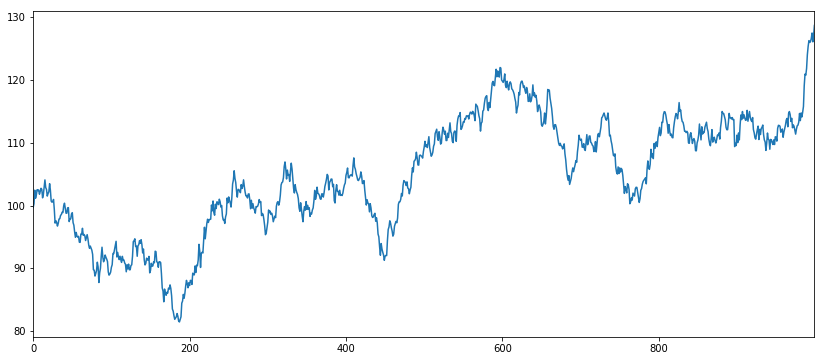

In [ ]:
# just set the seed for the random number generator
np.random.seed(2018)
# use returns to create a price series
drift = 100
r1 = np.random.normal(0, 1, 1000)
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.plot(figsize=(14,6))
plt.show()

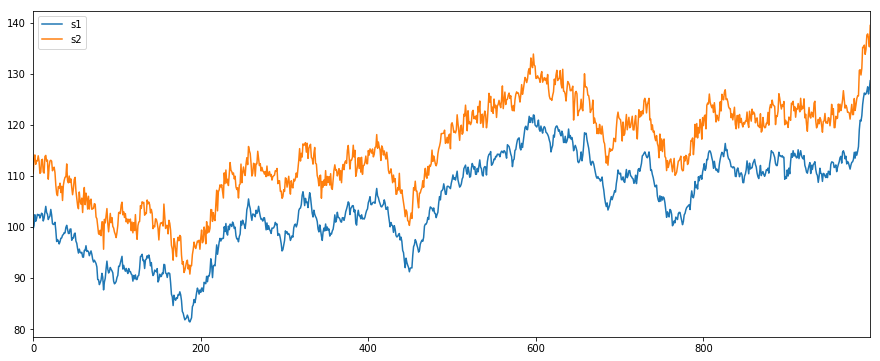

In [ ]:
offset = 10
noise = np.random.normal(0, 1, 1000)
s2 = s1 + offset + noise
s2.name = 's2'
pd.concat([s1, s2], axis=1).plot(figsize=(15,6))
plt.show()

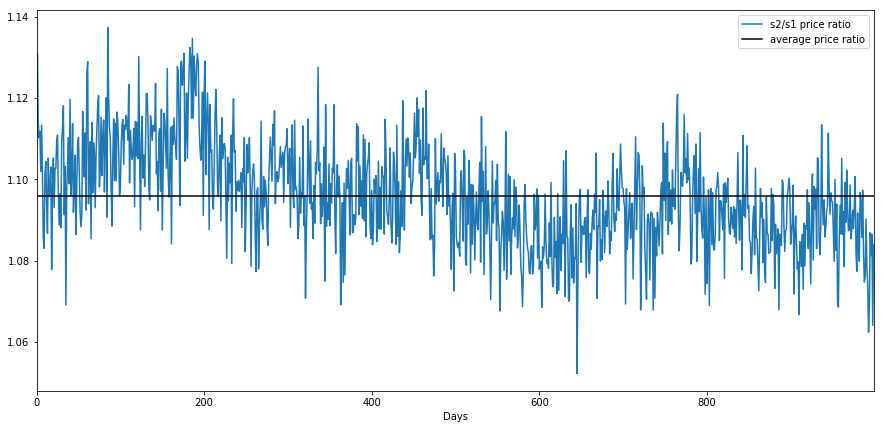

average price ratio 1.0960


In [ ]:
price_ratio = s2/s1
price_ratio.plot(figsize=(15,7))
plt.axhline(price_ratio.mean(), color='black')
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays

In [ ]:
type(s1)

pandas.core.series.Series

In [ ]:
type(s1.values)

numpy.ndarray

In [ ]:
s1.values.reshape(-1,1).shape

(1000, 1)

In [ ]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

1.002234357791276

In [ ]:
intercept = lr.intercept_[0]
intercept

9.753022747192901

In [ ]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 1.0022, intercept is 9.7530


Since the intercept is a constant, it's not necesary to include it in the spread, since it just shifts the spread up by a constant. We use the spread to check when it deviates from its historical average, so what matters going foward is how the spread differs from this average

## Calculate the spread

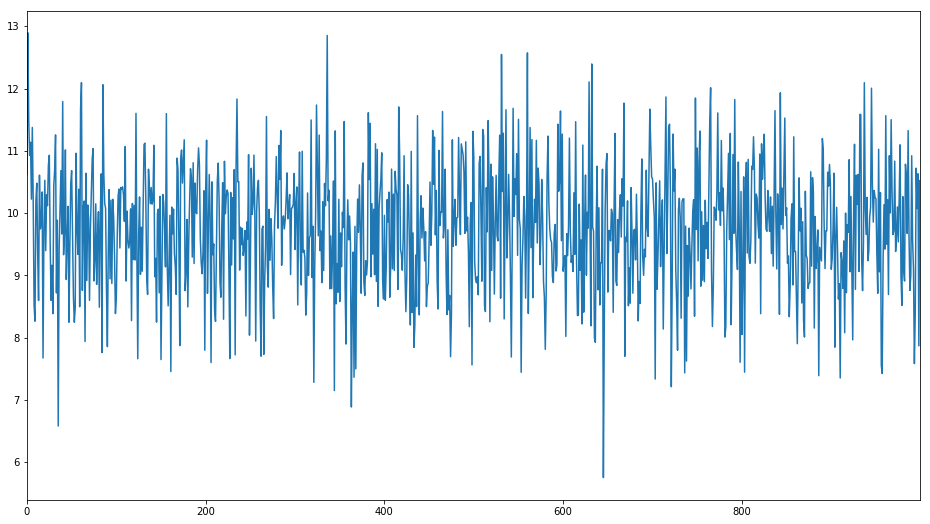

In [ ]:
spread = s2 - s1 * hedge_ratio
spread.plot()

In [ ]:
print(f"Average spread is {spread.mean()}")

Average spread is 9.753022747192913


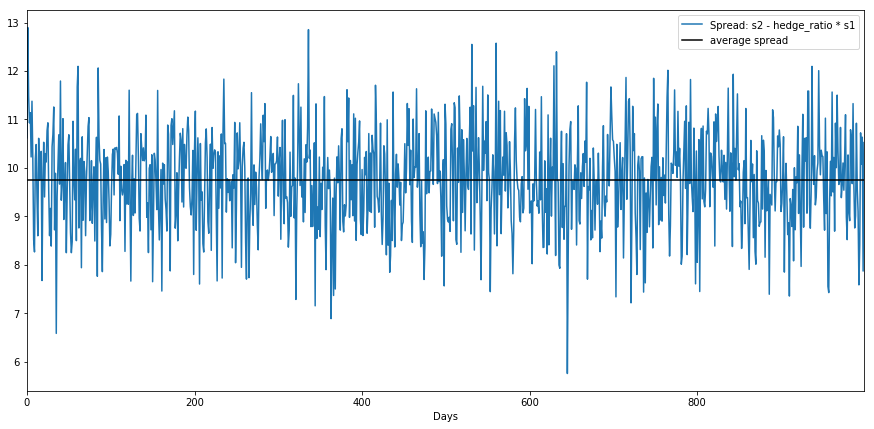

In [ ]:
spread.plot(figsize=(15,7))
plt.axhline(spread.mean(), color='black')
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

## Let's see what we get if we include the intercept of the regression

In [ ]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean()}")

Average spread with intercept included is 6.210143510543276e-15


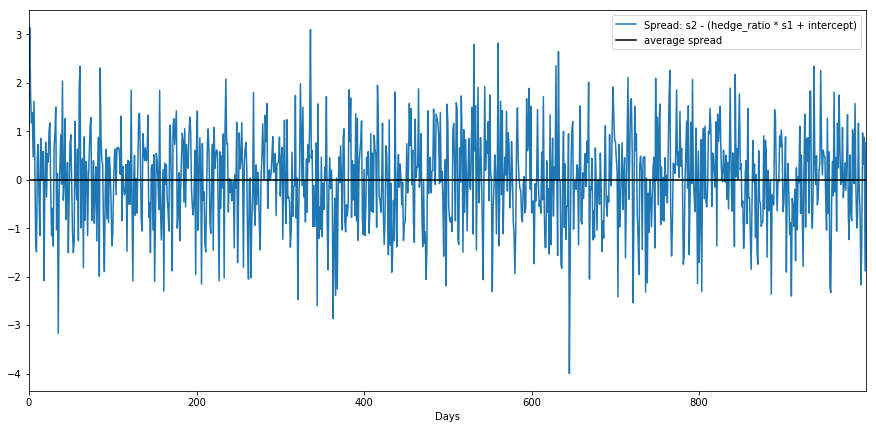

In [ ]:
spread_with_intercept.plot(figsize=(15,7))
plt.axhline(spread_with_intercept.mean(), color='black')
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread'])
plt.show()

### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [ ]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio

    p_level: level of significance required to reject null hypothesis of non-stationarity

    returns:
        True if spread can be considered stationary
        False otherwise
    """
    adf_result = adfuller(spread)
    pvalue = adf_result[1]
    print(f"pvalue {pvalue:.4f}")
    if pvalue <= p_level:
        print(f"pvalue is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue is > {p_level}, assume spread is not stationary")
        return False

In [ ]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread)}")

pvalue 0.0000
pvalue is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True
